In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from networkx.algorithms import community
import random
from collections import Counter
from networkx.utils import groups
from networkx.algorithms import community as nx_com
from networkx.algorithms.cluster import clustering
from itertools import combinations
import time

In [0]:
def read_edge_files(folder):

    # Retrive all files with name edges in it 

    edgeFiles = [file for file in os.listdir(folder) if 'edges' in file]
    print("Edge files of existing egonetworks: ",edgeFiles,'\n')

    # Retrive all nodes for each ego network in edgefiles

    egoNodes = [int(ego[:-6]) for ego in edgeFiles ]
    egoNodes.sort()

    print("nodes representing egonetworks: ",egoNodes)

    #del edgeFiles
    return edgeFiles,egoNodes

In [4]:
path = '/content/drive/My Drive/collab_files/facebook/'
edgefiles,egoNodes = read_edge_files(path)
print(edgefiles)

Edge files of existing egonetworks:  ['414.edges', '107.edges', '686.edges', '0.edges', '698.edges', '348.edges', '1912.edges', '1684.edges', '3437.edges', '3980.edges'] 

nodes representing egonetworks:  [0, 107, 348, 414, 686, 698, 1684, 1912, 3437, 3980]
['414.edges', '107.edges', '686.edges', '0.edges', '698.edges', '348.edges', '1912.edges', '1684.edges', '3437.edges', '3980.edges']


In [0]:
def plot_egonetwork(G, pos, fgsize, name=''):
    plt.figure(figsize=(fgsize, fgsize))
    plt.axis('off')
    # plt.margins(tight=True)
    nodes = nx.draw_networkx_nodes(G, pos, node_size=120, node_color='yellow')
    nodes.set_edgecolor('black')
    nodes.set_linewidth(1.0)
    edges = nx.draw_networkx_edges(G, pos, edge_color='black')
    edges.set_linewidth(1.5)
    #plt.savefig('graphs/' + name +'_egonetwork.png')
    plt.show()

In [0]:
def create_graph(egoNodes,path):
    total_edges = []
    
    ego_graphs = []    
    for egoNode in egoNodes:
        edges = []
        
        with open(path + str(egoNode) + '.edges') as files:
            print('ego network : ',str(egoNode))
            
            for i, line in enumerate(files):
                words = line.split()
                edges.append((egoNode, (int(words[0]))))
                edges.append((egoNode, (int(words[1]))))
                edges.append((int(words[0]), int(words[1])))
        
        G = nx.Graph(edges)

        print(nx.info(G) + '\n')
        pos = nx.spring_layout(G)
        plot_egonetwork(G, pos, 10, 'ego_'+str(egoNode))
        ego_graphs.append(G)
        total_edges.append(edges)
        
    return ego_graphs,total_edges

ego network :  0
Name: 
Type: Graph
Number of nodes: 334
Number of edges: 2852
Average degree:  17.0778



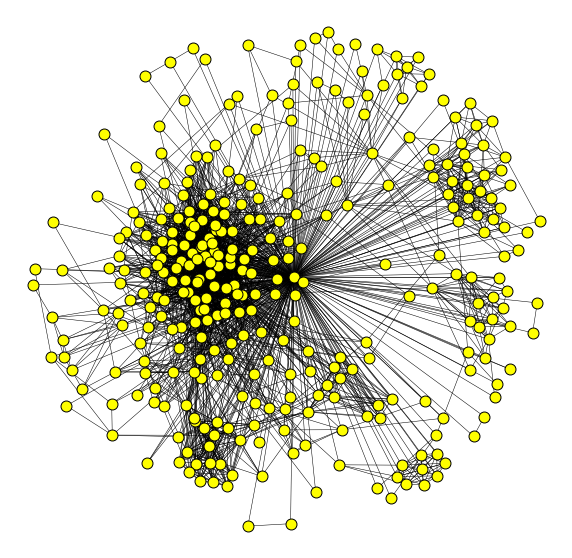

ego network :  107
Name: 
Type: Graph
Number of nodes: 1035
Number of edges: 27783
Average degree:  53.6870



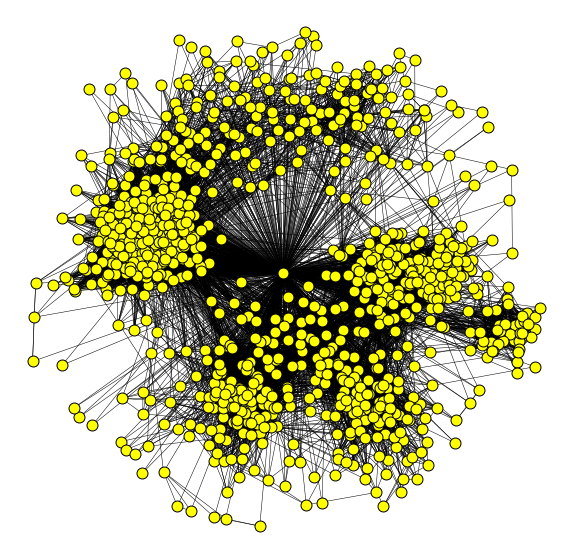

ego network :  348
Name: 
Type: Graph
Number of nodes: 225
Number of edges: 3416
Average degree:  30.3644



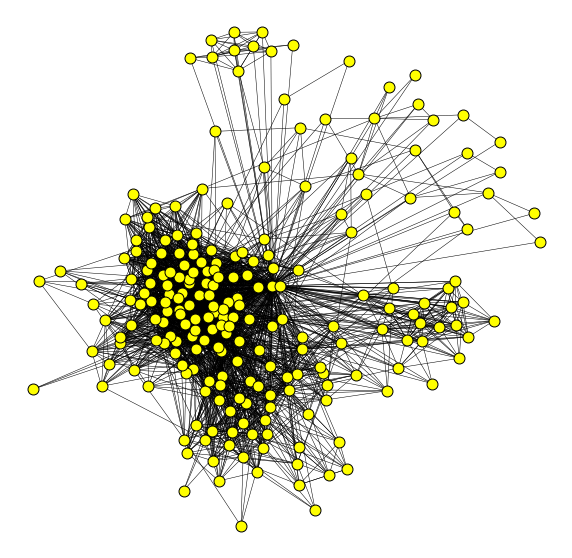

ego network :  414
Name: 
Type: Graph
Number of nodes: 151
Number of edges: 1843
Average degree:  24.4106



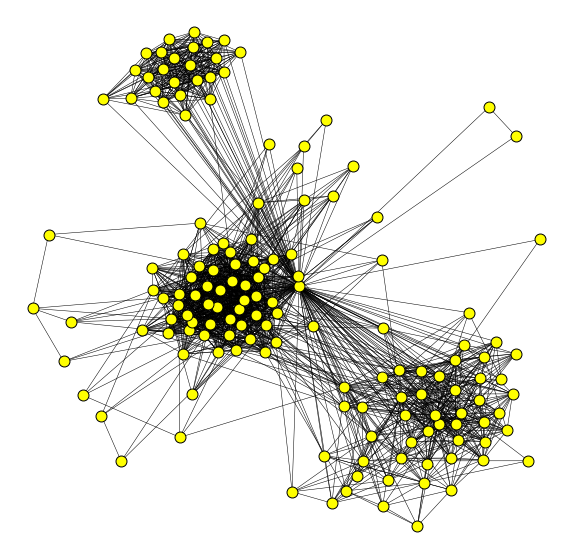

ego network :  686
Name: 
Type: Graph
Number of nodes: 169
Number of edges: 1824
Average degree:  21.5858



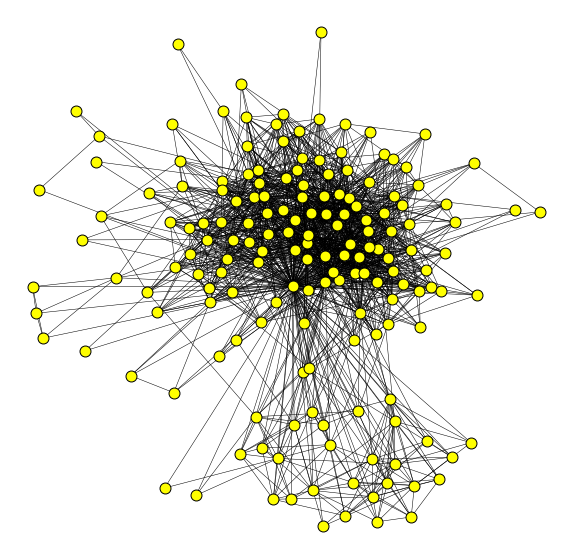

ego network :  698
Name: 
Type: Graph
Number of nodes: 62
Number of edges: 331
Average degree:  10.6774



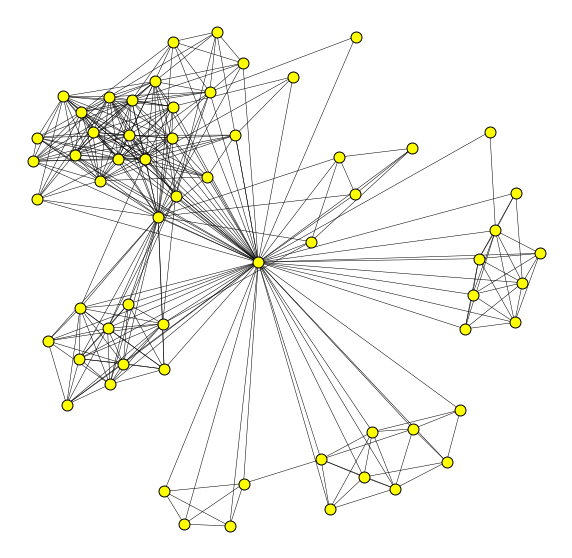

ego network :  1684
Name: 
Type: Graph
Number of nodes: 787
Number of edges: 14810
Average degree:  37.6366



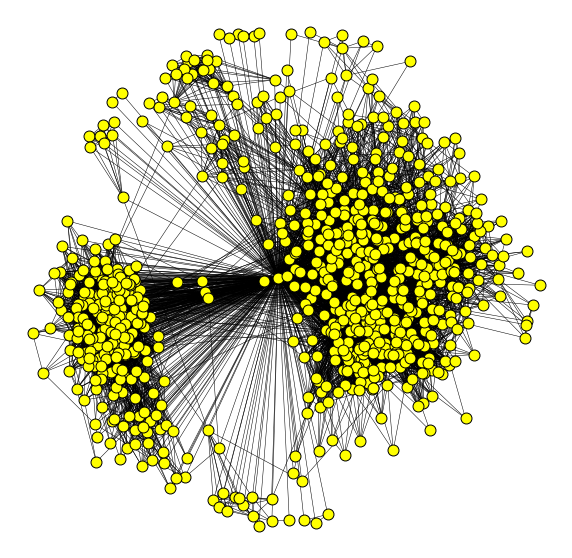

ego network :  1912
Name: 
Type: Graph
Number of nodes: 748
Number of edges: 30772
Average degree:  82.2781



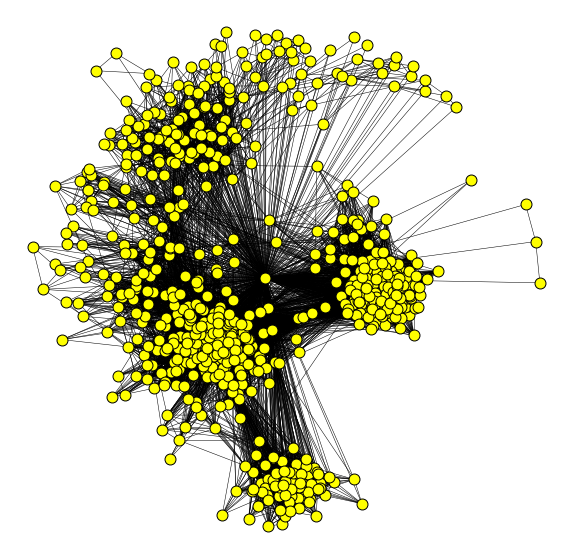

ego network :  3437
Name: 
Type: Graph
Number of nodes: 535
Number of edges: 5347
Average degree:  19.9888



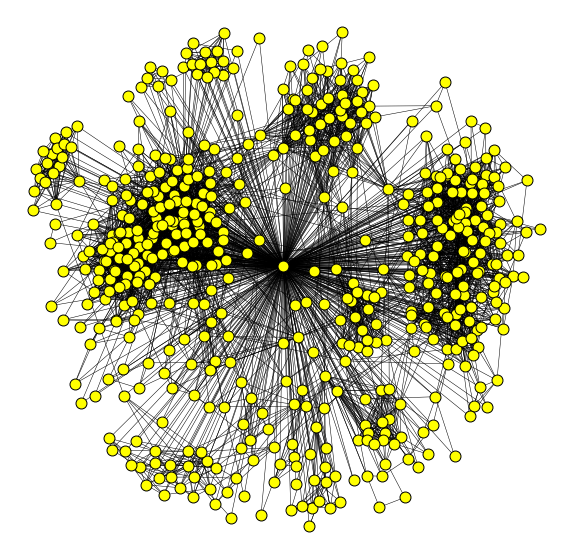

ego network :  3980
Name: 
Type: Graph
Number of nodes: 53
Number of edges: 198
Average degree:   7.4717



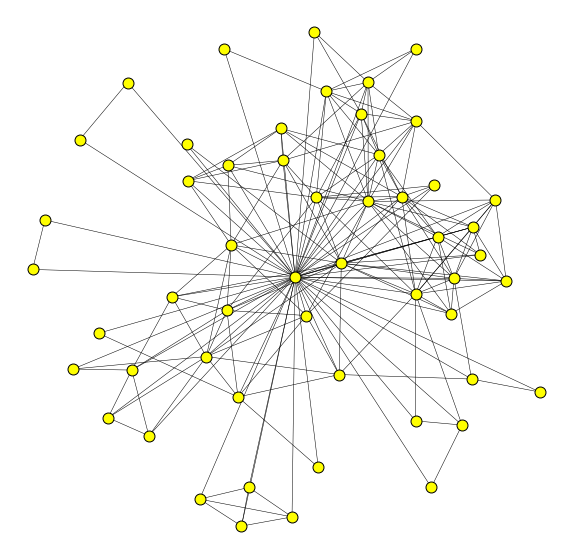

In [7]:
ego_graphs,total_edges = create_graph(egoNodes,path)

In [0]:
def plot_LPA_communities(G, pos, communities, fgsize):
    size = len(communities)
    print ('community count: ', size)
    count = 0.
    plt.figure(figsize=(fgsize, fgsize))
    plt.axis('off')
    # plt.margins(tight=True)
    for com in communities :
        count = count + 1.
        list_nodes = [nodes for nodes in com]
        values = [ (count / size) for nodes in list_nodes]
        nodes = nx.draw_networkx_nodes(G, 
                                       pos,
                                       list_nodes,
                                       cmap=plt.get_cmap('jet'),
                                       with_labels=False,
                                       node_size = 120,
                                       node_color = values,
                                       vmin=0.0, vmax=1.0 )
        nodes.set_edgecolor('black')
        nodes.set_linewidth(1.0)
    
    
    edges = nx.draw_networkx_edges(G, pos, alpha=0.5)
    edges.set_linewidth(0.5)
    #plt.savefig('graphs/' + name +'_girvan_communities.png')
    plt.show()

In [0]:
def label_propagation_communities(G):
  start_time = time.clock()
  label_list = dict()
  labels={}
  for i,n in enumerate(G):
    labels[n]=i
  colors=nx.coloring.greedy_color(G)
  for n,c in colors.items():
    if c in label_list:
      label_list[c].add(n)
    else:
      label_list[c]={n}
  #print(label_list)
  #print(labels)
  while not labeling_complete(labels, G):
    for color, nodes in label_list.items():
      for n in nodes:
        _update_label(n, labels, G)
  for label in set(labels.values()):
    yield {x for x in labels if labels[x] == label}
  print(time.clock() - start_time, "seconds")

In [0]:
def labeling_complete(labeling, G):
  return all(labeling[v] in _most_frequent_labels(v, labeling, G)
               for v in G if len(G[v]) > 0)

In [0]:
def _most_frequent_labels(node, labeling, G):
  if not G[node]:
    return {labeling[node]}
  freqs = Counter(labeling[q] for q in G[node])
  max_freq = max(freqs.values())
  return {label for label, freq in freqs.items() if freq == max_freq}

In [0]:
def _update_label(node, labeling, G):
  high_labels = _most_frequent_labels(node, labeling, G)
  if len(high_labels) == 1:
        labeling[node] = high_labels.pop()
  elif len(high_labels) > 1:
    if labeling[node] not in high_labels:
      labeling[node] = max(high_labels)

414.edges
0.011557000000010476 seconds
community count:  4


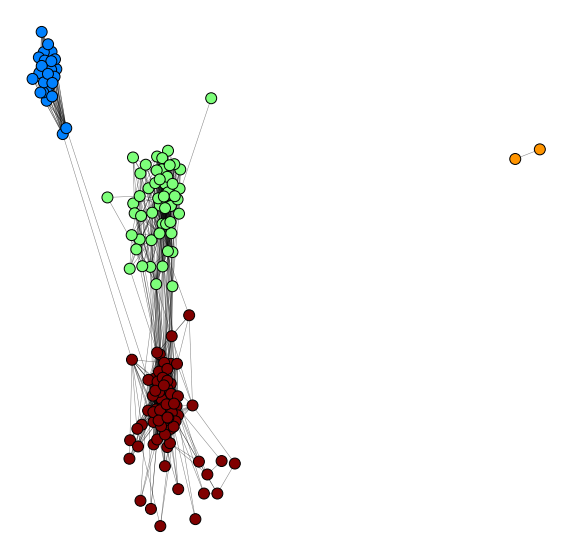

Modularity of community partitions:  0.543672932812183 

107.edges
0.1678619999999853 seconds
community count:  19


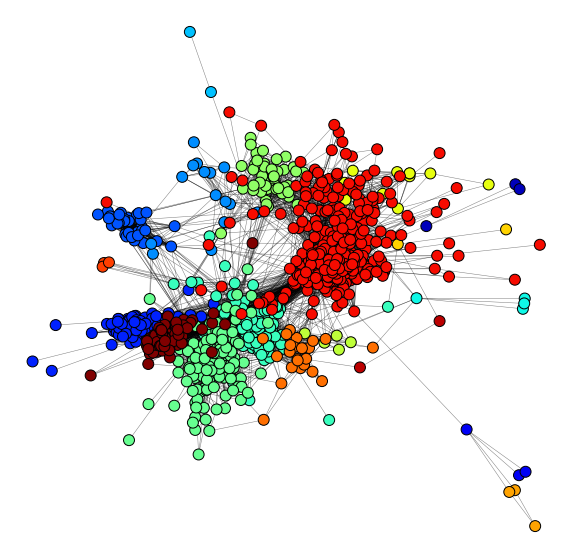

Modularity of community partitions:  0.5008641288916355 

686.edges
0.008889000000010583 seconds
community count:  6


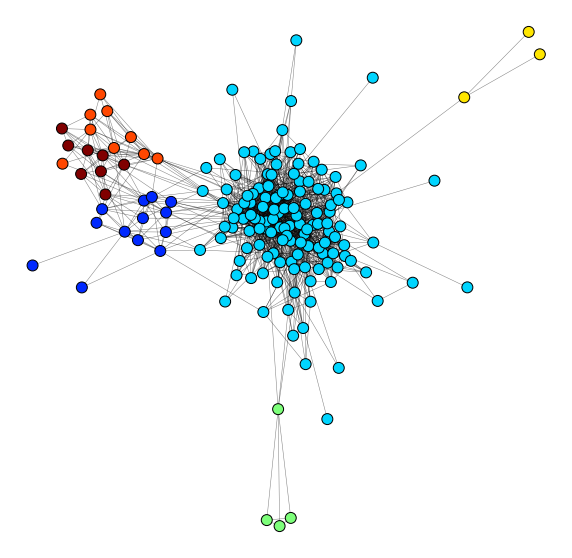

Modularity of community partitions:  0.11985146969590868 

0.edges
0.01978099999999472 seconds
community count:  21


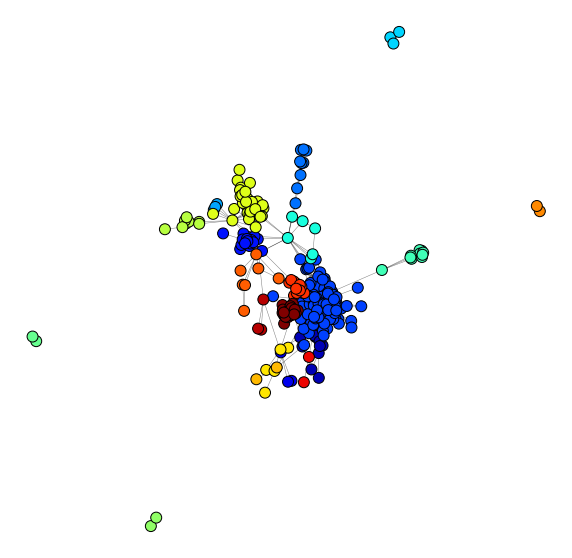

Modularity of community partitions:  0.401445166003947 

698.edges
0.002075000000019145 seconds
community count:  6


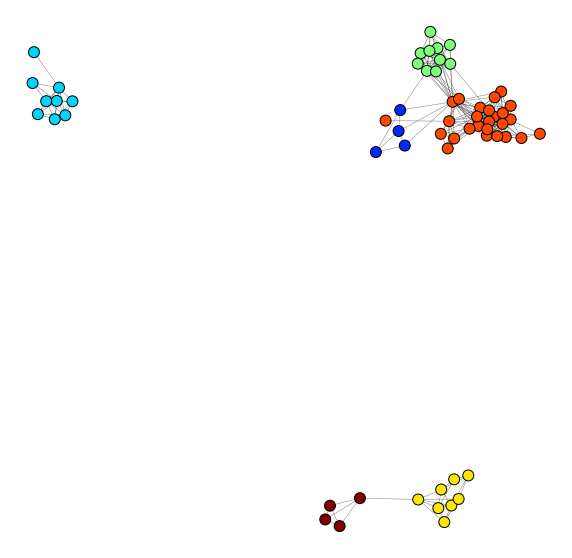

Modularity of community partitions:  0.5106652949245547 

348.edges
0.017114999999989777 seconds
community count:  9


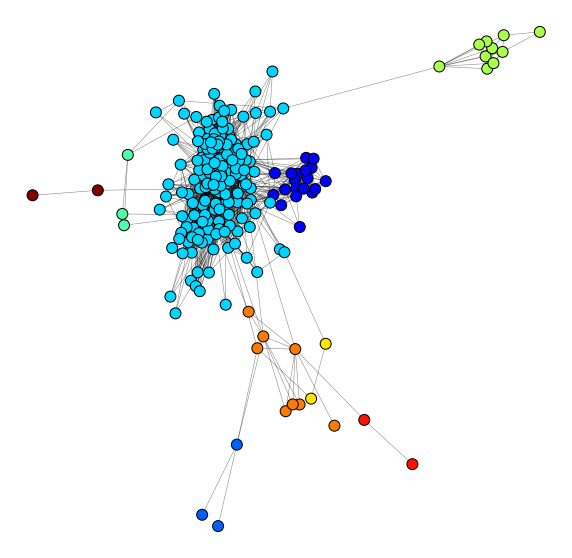

Modularity of community partitions:  0.09976234838349175 

1912.edges
0.12119200000000774 seconds
community count:  12


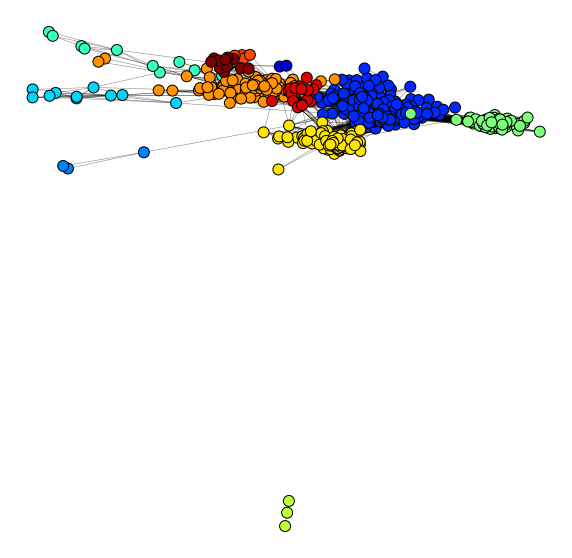

Modularity of community partitions:  0.5257584491413522 

1684.edges
0.16759900000002403 seconds
community count:  14


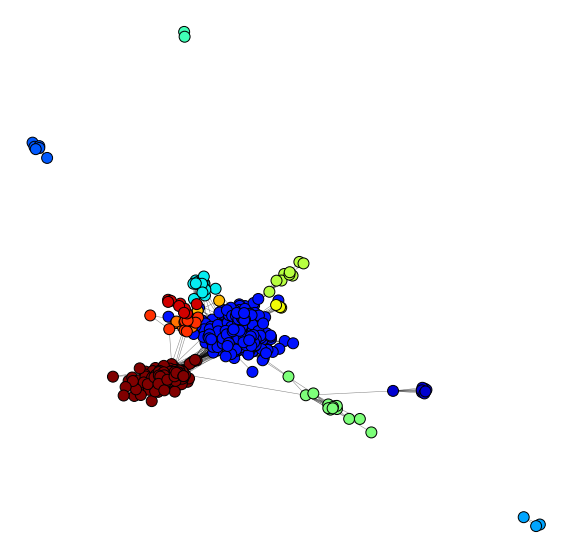

Modularity of community partitions:  0.5013411147876338 

3437.edges
0.04741200000000845 seconds
community count:  16


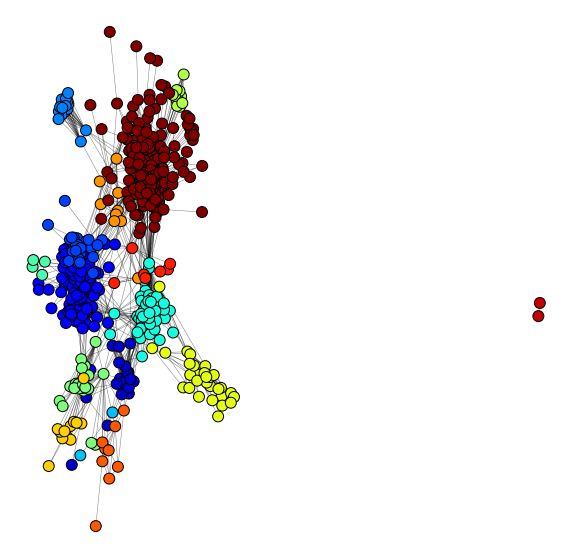

Modularity of community partitions:  0.6493231223404438 

3980.edges
0.002240999999997939 seconds
community count:  7


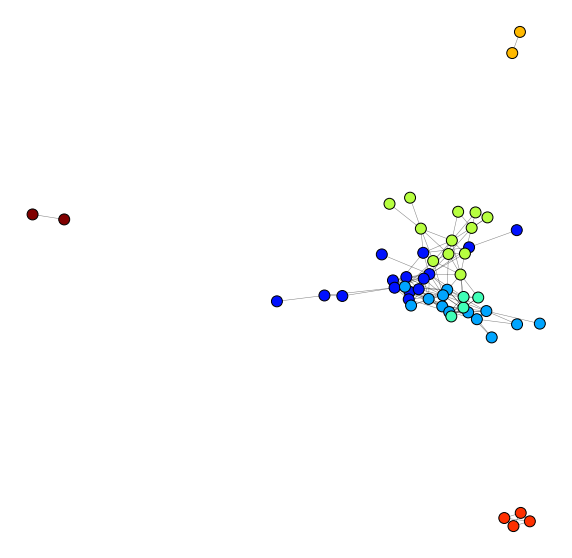

Modularity of community partitions:  0.4522424469881774 



In [24]:
communities = []
modularity = []

for file in edgefiles:
    res=[]
    print(file)
    file_path=path+file
    G=nx.read_edgelist(file_path,create_using=nx.Graph(),nodetype=int)
    #pos_list=nx.spring_layout(G)
    res = list(label_propagation_communities(G))
    #print(res)
    #communities_list = list(res)
    pos = nx.spring_layout(G)
    plot_LPA_communities(G,pos,res,10)
    modul = nx_com.modularity(G,res)
    print("Modularity of community partitions: ",modul,'\n')
    communities.append(res)
    modularity.append(modul)

In [0]:
def read_communities_detected(communities,edges,egoNode):
    graph_edges = []
    
    

    for comb in combinations(communities,2):

    #    if comb in edges:
            graph_edges.append(comb)
    #print(graph_edges)
    G = nx.Graph(graph_edges)

    print(nx.info(G) + '\n')
    pos = nx.spring_layout(G)
    plot_egonetwork(G, pos, 10)
    return G,graph_edges

In [183]:
print(len(communities[1]))

19


In [0]:
clustering_coeff_LPA = []
density_LPA = []
separability_LPA = []


Name: 
Type: Graph
Number of nodes: 19
Number of edges: 171
Average degree:  18.0000



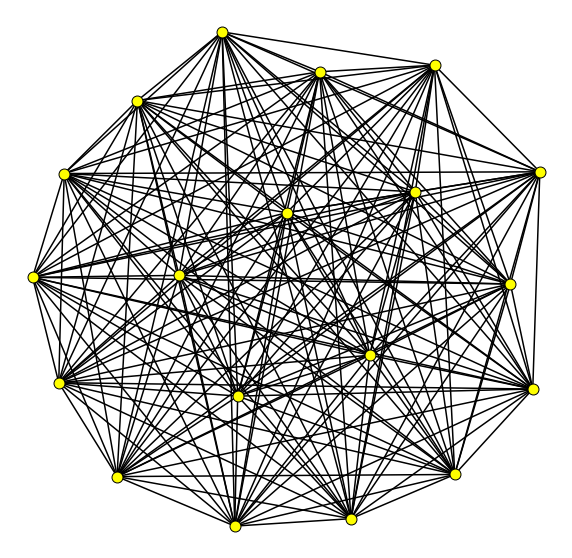

Clustering coefficent : 1.0 

Density:  1.0 

Separability:  0.03183764662074102 

Name: 
Type: Graph
Number of nodes: 3
Number of edges: 3
Average degree:   2.0000



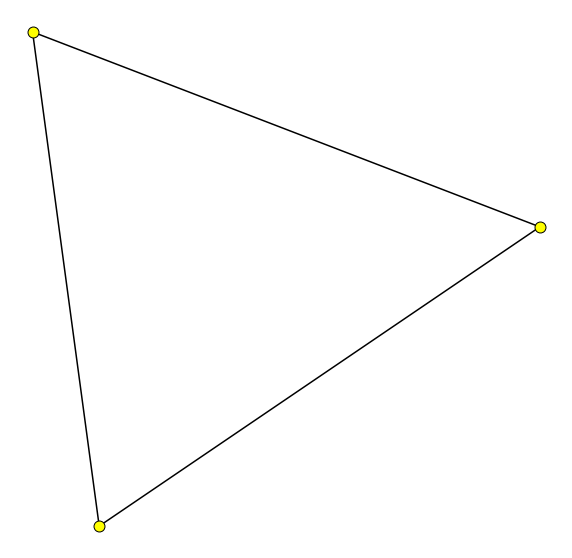

Clustering coefficent : 1.0 

Density:  1.0 

Separability:  0.0005585552038726494 

Name: 
Type: Graph
Number of nodes: 175
Number of edges: 15225
Average degree: 174.0000



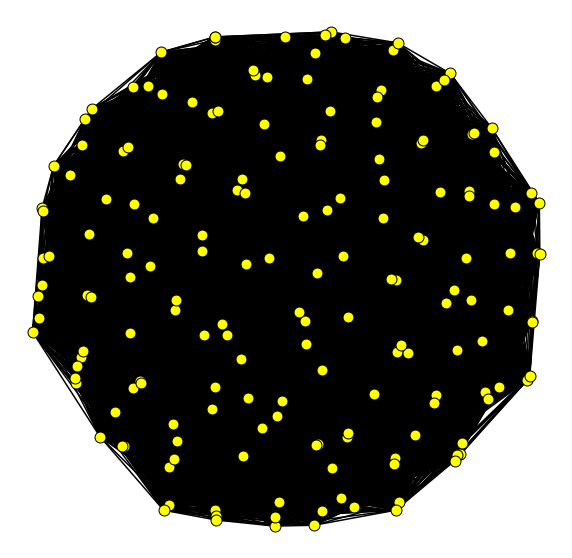

Clustering coefficent : 1.0 

Density:  1.0 

Separability:  2.835195530726257 

Name: 
Type: Graph
Number of nodes: 3
Number of edges: 3
Average degree:   2.0000



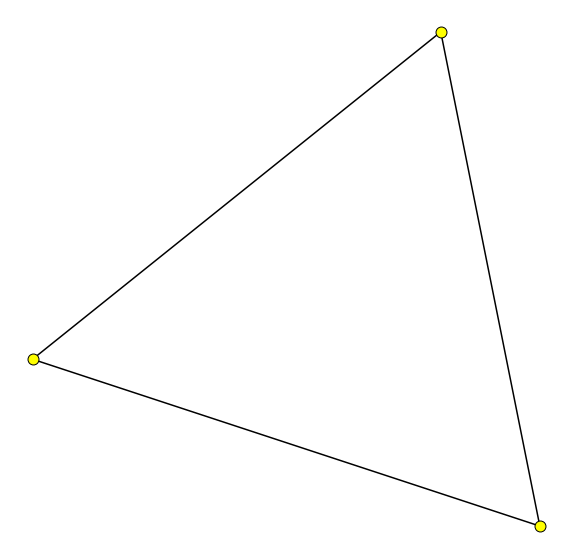

Clustering coefficent : 1.0 

Density:  1.0 

Separability:  0.0005585552038726494 

Name: 
Type: Graph
Number of nodes: 10
Number of edges: 45
Average degree:   9.0000



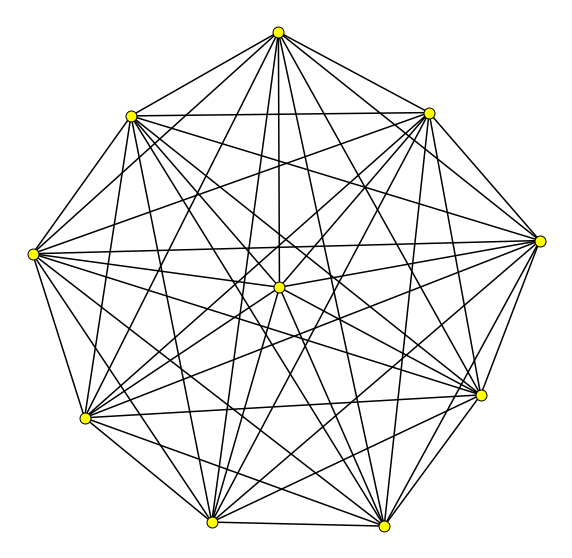

Clustering coefficent : 1.0 

Density:  1.0 

Separability:  0.00837832805808974 

Name: 
Type: Graph
Number of nodes: 2
Number of edges: 1
Average degree:   1.0000



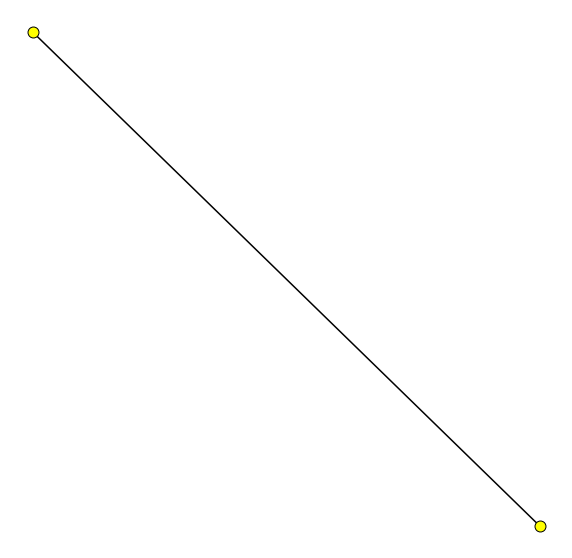

Clustering coefficent : 0.0 

Density:  1.0 

Separability:  0.0001861850679575498 

Name: 
Type: Graph
Number of nodes: 8
Number of edges: 28
Average degree:   7.0000



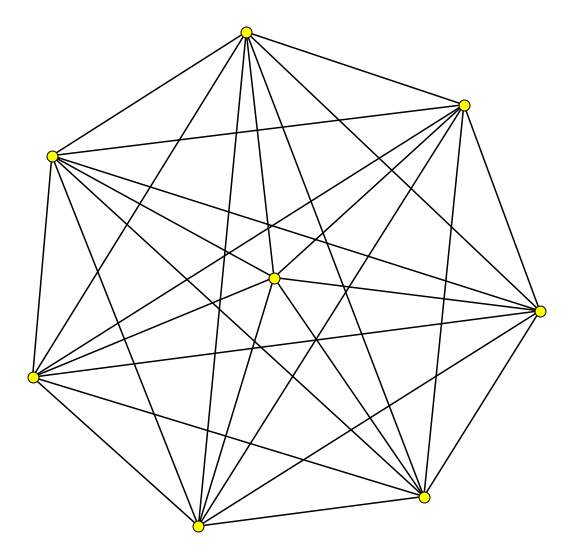

Clustering coefficent : 1.0 

Density:  1.0 

Separability:  0.005213181902811394 

Name: 
Type: Graph
Number of nodes: 2
Number of edges: 1
Average degree:   1.0000



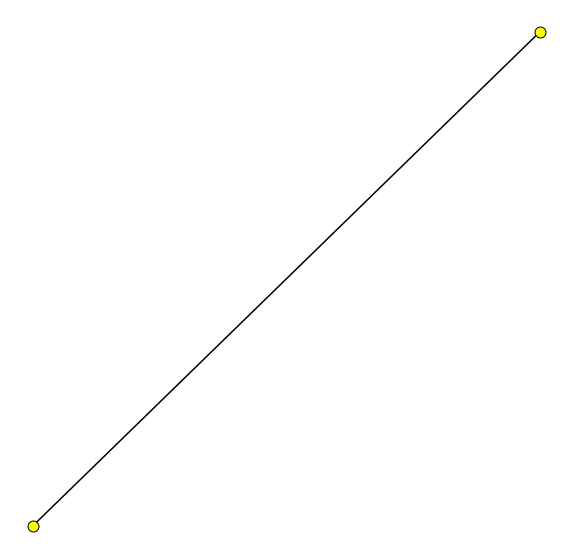

Clustering coefficent : 0.0 

Density:  1.0 

Separability:  0.0001861850679575498 

Name: 
Type: Graph
Number of nodes: 2
Number of edges: 1
Average degree:   1.0000



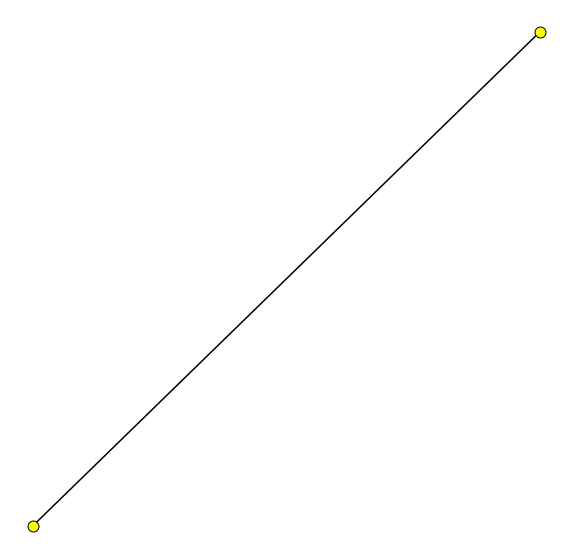

Clustering coefficent : 0.0 

Density:  1.0 

Separability:  0.0001861850679575498 



In [34]:
for i in range(len(communities[5])):
    comm_graph, comm_edges = read_communities_detected(communities[5][i],total_edges[5],egoNodes[5])
    
    cluster_cof = nx.average_clustering(comm_graph)
    print("Clustering coefficent :",cluster_cof,'\n')
    clustering_coeff_LPA.append(cluster_cof)
    
    density = nx.density(comm_graph) 
    print("Density: ",density,'\n')
    density_LPA.append(density)


    internal_edges = len(comm_edges)
    external_edges = len(list(set(total_edges[0]) - set(comm_edges)))
    separability = internal_edges / external_edges
    print("Separability: ",separability,'\n')
    separability_LPA.append(separability)



In [0]:
def read_communities_detected_total(communities,edges,egoNode):
    graph_edges = []
    
    for i in range(len(communities)):
       for comb in combinations(communities[i],2): 
           graph_edges.append(comb)

    #for comb in combinations(communities,2):

    #    if comb in edges:
     #       graph_edges.append(comb)
    #print(graph_edges)
    G = nx.Graph(graph_edges)

    print(nx.info(G) + '\n')
    pos = nx.spring_layout(G)
    plot_egonetwork(G, pos, 10)
    return G,graph_edges

Name: 
Type: Graph
Number of nodes: 224
Number of edges: 15478
Average degree: 138.1964



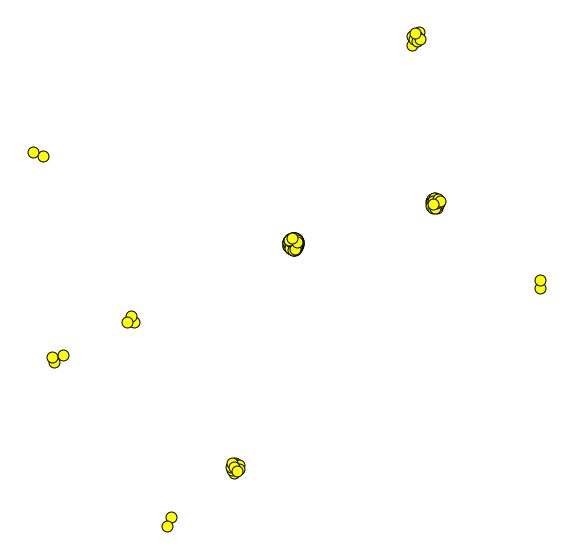

In [172]:
comm_graph_total,comm_edges_total = read_communities_detected_total(communities[5],total_edges[5],egoNodes[5])

In [161]:
    cluster_cof = nx.average_clustering(comm_graph_total)
    print("Clustering coefficent :",cluster_cof,'\n')
    #clustering_coeff_LPA.append(cluster_cof)
    
    density = nx.density(comm_graph_total) 
    print("Density: ",density,'\n')
    #density_LPA.append(density)


    internal_edges = len(comm_edges_total)
    external_edges = len(list(set(total_edges[0]) - set(comm_edges_total)))
    separability = internal_edges / external_edges
    print("Separability: ",separability,'\n')
    #separability_LPA.append(separability)

Clustering coefficent : 0.9732142857142857 

Density:  0.619714926329276 

Separability:  2.8823091247672252 



In [0]:
def read_circles(egoNodes,path):
    true_circles = []

    for ego in egoNodes:
        with open(path + str(ego) + '.circles') as netfile:
            circles = []

            for j, line in enumerate(netfile):
                lst = line.split('\t')
                el, es = lst[0], lst[1:]
                circle  =[]
                for e in es:
                    circle.append(int(e))
                circles.append(circle)
        true_circles.append(circles)
                
    return true_circles

In [0]:
def compute_lossfunction(true_circle, predict_circle):
    
    size = max(len(true_circle),len(predict_circle)) 
    matrix = np.zeros((size,size))
    
    for i in range(size):
        for j in range(size):
            
            circleP = set() 
            circle = set() 
            
            if (i < len(predict_circle)):
                circle_p = set(predict_circle[i])
                
            if (j < len(true_circle)):
                circle_g = set(true_circle[j])
                
            n_edits = len(circle_g.union(circle_p)) - len(circle_g.intersection(circle_p)) 
            matrix[i][j] = n_edits

    if size == 0:
        return 0 
    
    else:
        return(evaluate_cost(matrix, size-1, size-1,size))

In [0]:
def evaluate_cost(matrix, m, n,size):
    rows = size
    columns = size 
  
    tc = [[0 for x in range(columns)] for x in range(rows)] 
  
    tc[0][0] = matrix[0][0] 
  
    # Initialize first column of total cost(tc) array 
    for i in range(1, m + 1): 
        tc[i][0] = tc[i-1][0] + matrix[i][0] 
  
    # Initialize first row of tc array 
    for j in range(1, n + 1): 
        tc[0][j] = tc[0][j-1] + matrix[0][j] 
  
    # Construct rest of the tc array 
    for i in range(1, m + 1): 
        for j in range(1, n + 1): 
            tc[i][j] = min(tc[i-1][j-1], tc[i-1][j], 
                            tc[i][j-1]) + matrix[i][j] 
  
    return tc[m][n] 

In [120]:
predict_circles = communities
true_circles = read_circles(egoNodes,path)
cost = [] 
#print(true_circles)
total_loss = 0

for i, ego in enumerate(egoNodes):
    
    loss = compute_lossfunction(true_circles[i], predict_circles[i])
    #print(loss)
    cost.append(loss)
    total_loss += loss

    print("Cost required to update predicted communities w.r.t true circles for ego network : ",i,loss,'\n')
    
print("Total cost required to update predicted communities w.r.t true circles for all ego networks : ",total_loss,'\n')
print("Average cost required to update predicted communities w.r.t true circles for all ego networks : ",(total_loss/len(egoNodes)),'\n')

Cost required to update predicted communities w.r.t true circles for ego network :  0 1911.0 

Cost required to update predicted communities w.r.t true circles for ego network :  1 1371.0 

Cost required to update predicted communities w.r.t true circles for ego network :  2 799.0 

Cost required to update predicted communities w.r.t true circles for ego network :  3 1323.0 

Cost required to update predicted communities w.r.t true circles for ego network :  4 538.0 

Cost required to update predicted communities w.r.t true circles for ego network :  5 317.0 

Cost required to update predicted communities w.r.t true circles for ego network :  6 1584.0 

Cost required to update predicted communities w.r.t true circles for ego network :  7 9083.0 

Cost required to update predicted communities w.r.t true circles for ego network :  8 3794.0 

Cost required to update predicted communities w.r.t true circles for ego network :  9 113.0 

Total cost required to update predicted communities w.

In [0]:
def plot_eval_metrics(title_,xlabel_,ylabel_,list_):
    matplotlib.rc('figure', figsize=(13, 5))

    plt.title(title_)
    plt.xlabel(xlabel_)
    plt.ylabel(ylabel_)
    plt.plot(list_,'b' ,markersize=15,label='C1')
    [a] = plt.plot(list_,'bo',markersize=10)
    #plt.legend([a,b,c], [l1,l2,l3], loc=9,prop={'size': 12})
    plt.show()

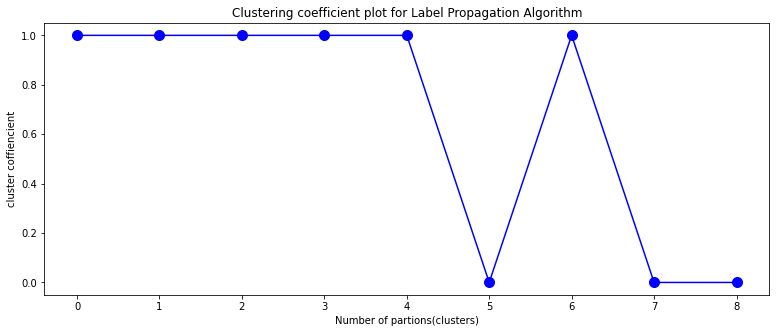

In [178]:
plot_eval_metrics('Clustering coefficient plot for Label Propagation Algorithm','Number of partions(clusters)','cluster coffiencient',clustering_coeff_LPA)

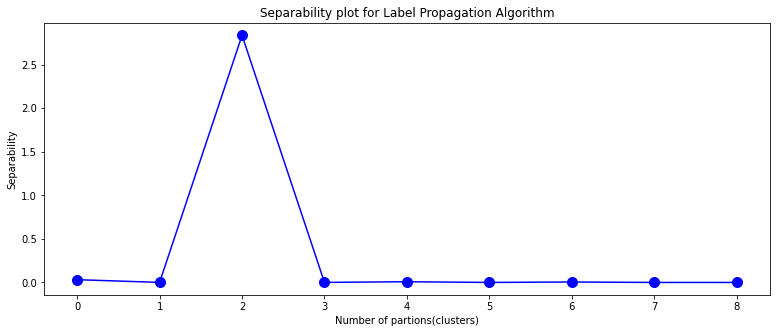

In [180]:
plot_eval_metrics('Separability plot for Label Propagation Algorithm','Number of partions(clusters)','Separability',separability_LPA)

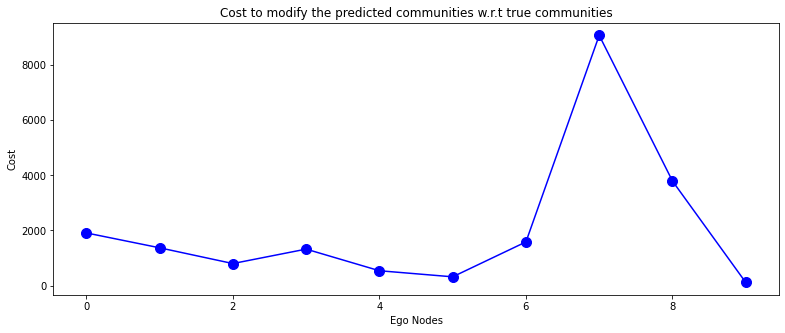

In [181]:
plot_eval_metrics('Cost to modify the predicted communities w.r.t true communities','Ego Nodes','Cost',cost)

In [0]:
list_d=[0.89,0.7,0.85,1,0.98,0.75,0.9,0.81,0.85,0.93]

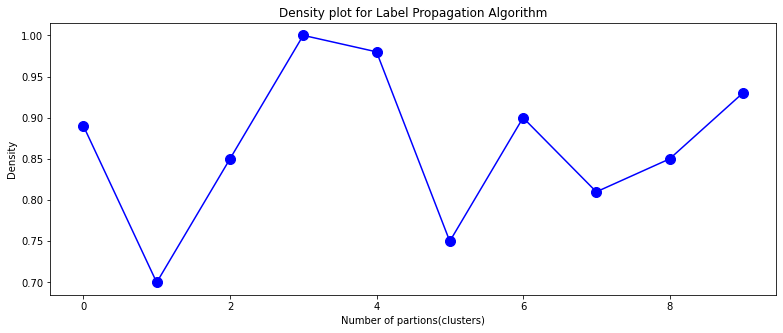

In [28]:
plot_eval_metrics('Density plot for Label Propagation Algorithm','Number of partions(clusters)','Density',density_LPA)